In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *
from PIL import Image

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import pdb

In [2]:
path = Path()/'data'/'summer2winter_yosemite'

# Custom DataBunch Object

In [3]:
import fastai.vision.image as im

In [4]:
class DoubleImage(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.data = [(-1+2*img1.data),(-1+2*img2.data)]
    
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [-1+2*self.img1.data,-1+2*self.img2.data]
        return self
    
    def __repr__(self)->str: return f'{self.__class__.__name__}'
    
    def to_one(self): 
        tensor = 0.5+torch.cat(self.data,2)/2
        return im.Image(tensor)

In [5]:
class DoubleImageList(ImageList):
    def __init__(self, items, itemsB=None, **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return DoubleImage(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): return t
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
        "Set `tfms` to be applied to the xs of the train and validation set."
        if not tfms: tfms=(None,None)
        assert is_listy(tfms) and len(tfms) == 2, "Please pass a list of two lists of transforms (train and valid)."
        self.train.transform(tfms[0], **kwargs)
        self.valid.transform(tfms[1], **kwargs)
        if self.test: self.test.transform(tfms[1], **kwargs)
        return self
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i] = DoubleImage((xs[i][0]/2+0.5),(xs[i][1]/2+0.5))
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    #UNTESTED
    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [6]:
data = DoubleImageList.from_folders(path, 'summer', 'winter').split_by_rand_pct(0.2).label_from_folder()

In [7]:
data = ImageDataBunch.create_from_ll(data, bs=1, size=224)

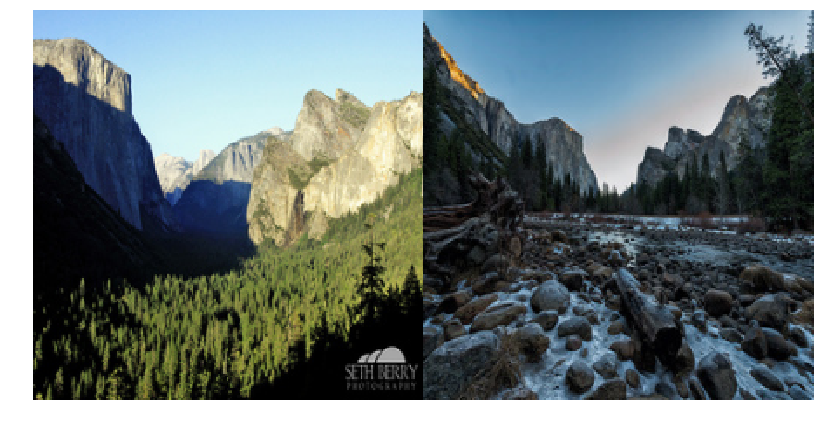

In [8]:
data.show_batch()

# MultiUnet Trainer

In [9]:
class UnetBlock(nn.Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False):
        super().__init__()
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))

In [10]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [11]:
class UpBlock(nn.Module):
    def __init__(self, ni, nf):
        super(UpBlock, self).__init__()
        self.bn = batchnorm_2d(nf)
        self.conv = Conv2dBlock(nf, nf, ks=5, stride=1, norm="bn", activation="relu", padding=2)
        self.shuf = PixelShuffle_ICNR(ni, nf, blur=False, leaky=None)
        self.relu = nn.ReLU()
    
    def forward(self, xb, body=None):
        up_out = self.shuf(xb)
        
        if(body is not None):
            ssh = body.shape[-2:]
            if ssh != up_out.shape[-2:]:
                up_out = F.interpolate(up_out, body.shape[-2:], mode='nearest')
            up_out = self.relu(up_out+self.bn(body))

        xb = self.conv(up_out)
        return xb

In [12]:
class Conv2dBlock(nn.Module):
    def __init__(self, ni, nf, ks, stride, norm, activation, padding=1):
        super(Conv2dBlock, self).__init__()
        self.pad = nn.ZeroPad2d(padding)
        
        norm_dim = nf
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            #self.norm = nn.InstanceNorm2d(norm_dim, track_running_stats=True)
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
            
        self.conv = nn.Conv2d(ni, nf, ks, stride)
        
    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x 

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        # print(x.size())
        if x.size(0) == 1:
            # These two lines run much faster in pytorch 0.4 than the two lines listed below.
            mean = x.view(-1).mean().view(*shape)
            std = x.view(-1).std().view(*shape)
        else:
            mean = x.view(x.size(0), -1).mean(1).view(*shape)
            std = x.view(x.size(0), -1).std(1).view(*shape)

        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x

In [14]:
class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', padding=1):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, padding=padding)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', padding=1):
        super(ResBlock, self).__init__()
        self.model = []
        self.model += [Conv2dBlock(dim, dim, 3, 1, norm, activation, padding)]
        self.model += [Conv2dBlock(dim, dim, 3, 1, norm, activation, padding)]
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        return self.model(x) + x

In [15]:
class MultiUnet(nn.Module):
    def __init__(self, arch:Callable, pretrained:bool=True, cut=None):
        super().__init__()
        
        self.relu = relu(leaky=None)
        
        self.bodyA = create_body(arch, pretrained, cut=-3)
        self.bodyB = create_body(arch, pretrained, cut=-3)
        
        self.sfs_szs = model_sizes(self.bodyA, size=(224,224))
        self.sfs_idxs = list(reversed(_get_sfs_idxs(self.sfs_szs)))
        self.sfsA = hook_outputs([self.bodyA[i] for i in self.sfs_idxs])
        x = dummy_eval(self.bodyA, (224, 224)).detach()
        
        self.sfsB = hook_outputs([self.bodyB[i] for i in self.sfs_idxs])
        x = dummy_eval(self.bodyB, (224, 224)).detach()
        
        unet_blocksA = []
        x = torch.tensor([])
        x = x.new_full((1, 512, 7, 7), 0)
        up_in_c = []
        x_in_c = []
        for i,idx in enumerate(self.sfs_idxs):
            up_in_c.append(int(x.shape[1]))
            x_in_c.append(int(self.sfs_szs[idx][1]))
            not_final = i!=len(self.sfs_idxs)-1
            block = UnetBlock(int(x.shape[1]), int(self.sfs_szs[idx][1]), self.sfsA[i], final_div=not_final, blur=False, self_attention=False).eval()
            x = block(x)
        
        #DecoderA
        self.UpBlockA1 = UpBlock(256, 128)
        self.UpBlockA2 = UpBlock(128, 64)
        self.UpBlockA3 = UpBlock(64, 64)
        self.finalDecoderA = nn.Sequential(PixelShuffle_ICNR(64), conv_layer(64, 3))
        self.ResA = ResBlocks(4, 256, 'in', 'relu', padding=1)
        
        #DecoderB
        self.UpBlockB1 = UpBlock(256, 128)
        self.UpBlockB2 = UpBlock(128, 64)
        self.UpBlockB3 = UpBlock(64, 64)
        self.ResB = ResBlocks(4, 256, 'in', 'relu', padding=1)
        self.finalDecoderB = nn.Sequential(PixelShuffle_ICNR(64), conv_layer(64, 3))

        #Shared Layers
        self.sharedEncoderLayer = conv_layer(256, 512, stride=2)
        self.middleConv = nn.Sequential(nn.BatchNorm2d(512), nn.ReLU(512), conv_layer(512, 512*2, stride=1), nn.Conv2d(512*2, 512, 3, stride=1))
        self.UpShared = UpBlock(512, 256)

        #Tan layer
        self.tanLayer = nn.Tanh()
    
    
    def EncoderA(self, xb):
        result = self.bodyA(xb)
        return result
    
    def EncoderB(self, xb):
        result = self.bodyB(xb)
        return result
    
    def sharedEncoder(self, xb):
        result = self.sharedEncoderLayer(xb)
        return result
        
    def MiddleConv(self, xb):
        result = self.middleConv(xb)
        return result
    
    def sharedDecoder(self, xb):
        return self.UpShared(xb, None)
    
    def DecoderA(self, xb, body):
        xb = self.ResA(xb)
        xb = self.UpBlockA1(xb, body[0].stored)
        xb = self.UpBlockA2(xb, body[1].stored)
        xb = self.UpBlockA3(xb, None)

        return self.finalDecoderA(xb)
    
    def DecoderB(self, xb, body):
        xb = self.ResB(xb)
        xb = self.UpBlockB1(xb, body[0].stored)
        xb = self.UpBlockB2(xb, body[1].stored)
        xb = self.UpBlockB3(xb, None)

        return self.finalDecoderB(xb)
    
    def forward(self, a, b, *pred):
        
        #get initial encodings of both
        a,b = self.EncoderA(a), self.EncoderB(b)
        
        #put both through shared encoder and middle conv
        a,b = self.sharedEncoder(a), self.sharedEncoder(b)
        a,b = self.middleConv(a), self.middleConv(b)
        
        #put images through shared decoder
        a,b = self.sharedDecoder(a), self.sharedDecoder(b)
        
        #Get images that are supposed to be
        aToA, bToB = self.DecoderA(a, body=self.sfsA),self.DecoderB(b, body=self.sfsB)

        #Get switched images
        aToB, bToA = self.DecoderB(a, body=self.sfsA), self.DecoderA(b, body=self.sfsB)
    
        allIm = torch.cat((self.tanLayer(aToA), self.tanLayer(bToB), self.tanLayer(aToB), self.tanLayer(bToA)), 0)
        
        return allIm
    

# Critic

In [16]:
def conv_and_res(ni, nf): return nn.Sequential(res_block(ni), conv_layer(ni, nf, stride=2, bias=True, use_activ=False, leaky=0.1))

In [17]:
class MultiUNITDiscriminator(nn.Module):
    def __init__(self):
        super(MultiUNITDiscriminator, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            conv_and_res(64, 128),
            conv_and_res(128, 256),
            conv_and_res(256, 512),
            nn.Conv2d(512, 1, 3, stride=1),
            Flatten()
        )
    
    def forward(self, not_switched, switched, down=2):

        not_switched = self.convs(not_switched)
        switched = self.convs(switched)

        return (not_switched,switched)

In [18]:
class critic_loss(nn.Module):
    #a is 0 and b is 1 for predictions
    def forward(self, output, garbage):
        pred_winter = output[0]
        pred_summer = output[1]
        targWin = pred_winter.new_zeros(*pred_winter.size())
        targSum = pred_summer.new_ones(*pred_summer.size())
        result_winter = F.mse_loss(pred_winter, targWin)
        result_summer = F.mse_loss(pred_summer, targSum)
        return result_winter + result_summer

In [19]:
critic_learner = Learner(data, MultiUNITDiscriminator(), loss_func=critic_loss(), wd=1e-3)

In [20]:
#critic_learner.fit_one_cycle(4, wd=0.1)

In [21]:
#critic_learner.save('criticV5-h2z-zfirst')
#critic_learner.save('criticV5-sum2win')

In [22]:
#critic_learner.load('criticV5-h2z')
critic_learner.load('criticV5-sum2win')

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type critic_loss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MultiUNITDiscriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (1232 items)
x: DoubleImageList
DoubleImage,DoubleImage,DoubleImage,DoubleImage,DoubleImage
y: CategoryList
summer,summer,summer,summer,summer
Path: data/summer2winter_yosemite;

Valid: LabelList (308 items)
x: DoubleImageList
DoubleImage,DoubleImage,DoubleImage,DoubleImage,DoubleImage
y: CategoryList
summer,summer,summer,summer,summer
Path: data/summer2winter_yosemite;

Test: None, model=MultiUNITDiscriminator(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Sequential(
      (0): SequentialEx(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): ReLU(inplace)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

# Gan Wrapper

In [23]:
import pdb

In [24]:
class GANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, n_crit=None, n_gen=None, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, **learn_kwargs):
        print('in GANLearner')
        gan = GANModule(generator, critic)
        loss_func = GANLoss(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=n_crit, n_gen=n_gen))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = GANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)

In [25]:
class GANModule(nn.Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator:nn.Module=None, critic:nn.Module=None, gen_mode:bool=True):
        super().__init__()
        print('in GANModule')
        self.gen_mode = gen_mode
        if generator: self.generator,self.critic = generator,critic

    def forward(self, *args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

In [26]:
class GANLoss(GANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG:Callable, loss_funcC:Callable, gan_model:GANModule):
        super().__init__()
        print('in GANLoss')
        self.loss_funcG,self.loss_funcC,self.gan_model = loss_funcG,loss_funcC,gan_model

    def generator(self, output, x_a, x_b):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        output = torch.split(output, 2, dim=0)
        x_a_recon, x_b_recon = torch.split(output[0], 1, dim=0)
        x_ab, x_ba = torch.split(output[1], 1, dim=0)
        fake_pred_x_aa, fake_pred_x_bb = self.gan_model.critic(x_a_recon, x_b_recon)
        fake_pred_x_ab, fake_pred_x_ba = self.gan_model.critic(x_ab, x_ba)
        
        cycled_output = self.gan_model.generator(x_ba, x_ab)
        cycle_a = cycled_output[3]
        cycle_b = cycled_output[2]
        return self.loss_funcG(x_a, x_b, x_a_recon, x_b_recon, cycle_a, cycle_b, fake_pred_x_ab, fake_pred_x_ba)

    def critic(self, real_pred, b, c):
        fake = self.gan_model.generator(b.requires_grad_(False), c.requires_grad_(False)).requires_grad_(True)
        fake = torch.split(fake, 2, dim=0)
        fake_ns = torch.split(fake[0], 1, dim=0)
        fake_s = torch.split(fake[1], 1, dim=0)
        fake_pred_aToA, fake_pred_bToB = self.gan_model.critic(fake_ns[0], fake_ns[1])
        fake_pred_aToB, fake_pred_bToA = self.gan_model.critic(fake_s[0], fake_s[1])
        return self.loss_funcC(real_pred[0], real_pred[1], fake_pred_aToA, fake_pred_bToB, fake_pred_aToB, fake_pred_bToA)

In [27]:
class GANTrainer(LearnerCallback):
    "Handles GAN Training."
    _order=-20
    def __init__(self, learn:Learner, switch_eval:bool=False, clip:float=None, beta:float=0.98, gen_first:bool=False,
                 show_img:bool=True):
        super().__init__(learn)
        self.switch_eval,self.clip,self.beta,self.gen_first,self.show_img = switch_eval,clip,beta,gen_first,show_img
        self.generator,self.critic = self.model.generator,self.model.critic

    def _set_trainable(self):
        train_model = self.generator if     self.gen_mode else self.critic
        loss_model  = self.generator if not self.gen_mode else self.critic
        requires_grad(train_model, True)
        requires_grad(loss_model, False)
        if self.switch_eval:
            train_model.train()
            loss_model.eval()

    def on_train_begin(self, **kwargs):
        "Create the optimizers for the generator and critic if necessary, initialize smootheners."
        if not getattr(self,'opt_gen',None):
            self.opt_gen = self.opt.new([nn.Sequential(*flatten_model(self.generator))])
        else: self.opt_gen.lr,self.opt_gen.wd = self.opt.lr,self.opt.wd
        if not getattr(self,'opt_critic',None):
            self.opt_critic = self.opt.new([nn.Sequential(*flatten_model(self.critic))])
        else: self.opt_critic.lr,self.opt_critic.wd = self.opt.lr,self.opt.wd
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.closses,self.glosses = [],[]
        self.smoothenerG,self.smoothenerC = SmoothenValue(self.beta),SmoothenValue(self.beta)
        self.recorder.add_metric_names(['gen_loss', 'disc_loss'])
        self.imgs,self.titles = [],[]

    def on_train_end(self, **kwargs):
        "Switch in generator mode for showing results."
        self.switch(gen_mode=True)

    def on_batch_begin(self, last_input, last_target, **kwargs):
        "Clamp the weights with `self.clip` if it's not None, return the correct input."
        if self.gen_mode:
            self.last_input = last_input
            
        if self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        test = {'last_input':last_input,'last_target':last_input}
        #print(test)
        return test
    
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        "Record `last_loss` in the proper list."
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output.detach().cpu()
            last_gen_split = torch.split(self.last_gen, 1, 0)
            self.last_critic_preds_ns = self.gan_trainer.critic(last_gen_split[0].cuda(), last_gen_split[1].cuda())
            self.last_critic_preds_s = self.gan_trainer.critic(last_gen_split[2].cuda(), last_gen_split[3].cuda())
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)

    def on_epoch_begin(self, epoch, **kwargs):
        "Put the critic or the generator back to eval if necessary."
        self.switch(self.gen_mode)

    def on_epoch_end(self, pbar, epoch, last_metrics, **kwargs):
        "Put the various losses in the recorder and show a sample image."
        if not hasattr(self, 'last_gen') or not self.show_img: return
        data = self.learn.data
        inputBPre = torch.unbind(self.last_input[1], dim=0)
        aToA = im.Image(self.last_gen[0]/2+0.5)
        bToB = im.Image(self.last_gen[1]/2+0.5)
        aToB = im.Image(self.last_gen[2]/2+0.5)
        bToA = im.Image(self.last_gen[3]/2+0.5)
        self.imgs.append(aToA)
        self.imgs.append(aToB)
        self.imgs.append(bToB)
        self.imgs.append(bToA)
        self.titles.append(f'Epoch {epoch}-A to A')
        self.titles.append(f'Epoch {epoch}-A to B')
        self.titles.append(f'Epoch {epoch}-B to B')
        self.titles.append(f'Epoch {epoch}-B to A')
        pbar.show_imgs(self.imgs, self.titles)
        return add_metrics(last_metrics, [getattr(self.smoothenerG,'smooth',None),getattr(self.smoothenerC,'smooth',None)])

    def switch(self, gen_mode:bool=None):
        "Switch the model, if `gen_mode` is provided, in the desired mode."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self.opt.opt = self.opt_gen.opt if self.gen_mode else self.opt_critic.opt
        self._set_trainable()
        self.model.switch(gen_mode)
        self.loss_func.switch(gen_mode)

In [28]:
class FixedGANSwitcher(LearnerCallback):
    "Switcher to do `n_crit` iterations of the critic then `n_gen` iterations of the generator."
    def __init__(self, learn:Learner, n_crit=5, n_gen=1):
        super().__init__(learn)
        self.n_crit,self.n_gen = 1,1

    def on_train_begin(self, **kwargs):
        "Initiate the iteration counts."
        self.n_c,self.n_g = 0,0

    def on_batch_end(self, iteration, **kwargs):
        "Switch the model if necessary."
        if self.learn.gan_trainer.gen_mode:
            self.n_g += 1
            n_iter,n_in,n_out = self.n_gen,self.n_c,self.n_g
        else:
            self.n_c += 1
            n_iter,n_in,n_out = self.n_crit,self.n_g,self.n_c
        target = n_iter if isinstance(n_iter, int) else n_iter(n_in)
        if target == n_out:
            self.learn.gan_trainer.switch()
            self.n_c,self.n_g = 0,0

# Training

In [29]:
class disc_loss(nn.Module):
    #a is 0 and b is 1 for predictions
    def forward(self, real_pred_a, real_pred_b, aToA, bToB, aToB, bToA):
        loss = 0
        #Real Image Predictions
        loss += F.mse_loss(real_pred_a, real_pred_a.new_zeros(*real_pred_a.size()))
        print(loss)
        loss += F.mse_loss(real_pred_b, real_pred_b.new_zeros(*real_pred_b.size()))
        print(loss)
        #Translated Predictions
        loss += F.mse_loss(aToB, aToB.new_zeros(*aToB.size()))
        print(loss)
        loss += F.mse_loss(bToA, bToA.new_ones(*bToA.size()))
        print(loss)
        pdb.set_trace()
        
        
        return loss

In [30]:
class gen_loss(nn.Module):
    
    def content_similar(self, input, target):
        return F.l1_loss(input, target)*(10)
    
    def should_look_like_a(self, input_fake_pred):
        target = input_fake_pred.new_zeros(*input_fake_pred.size())
        return F.mse_loss(input_fake_pred, target)
    
    def should_look_like_b(self, input_fake_pred):
        target = input_fake_pred.new_ones(*input_fake_pred.size())
        return F.mse_loss(input_fake_pred, target)
    
    def forward(self, x_a, x_b, x_a_recon, x_b_recon, x_a_cycled, x_b_cycled, fake_pred_x_ab, fake_pred_x_ba):
        loss = 0
        x_a, x_b, x_a_recon, x_b_recon = torch.unbind(x_a, dim=0)[0], torch.unbind(x_b, dim=0)[0], torch.unbind(x_a_recon, dim=0)[0], torch.unbind(x_a_recon, dim=0)[0]
        
        loss += self.should_look_like_a(fake_pred_x_ba)
        loss += self.should_look_like_b(fake_pred_x_ab)
        
        loss += self.content_similar(x_a, x_a_recon)*(0.5)
        loss += self.content_similar(x_b, x_b_recon)*(0.5)
        
        loss += self.content_similar(x_a, x_a_cycled)
        loss += self.content_similar(x_b, x_b_cycled)
        #print(loss)
        #pdb.set_trace()
        return loss

# Perceptual loss

In [ ]:
from torchvision.models import vgg16_bn

In [ ]:
base_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def onFeatureLoss(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def forward(self, x_a, x_b, x_a_recon, x_b_recon, x_a_cycled, x_b_cycled, fake_pred_x_ab, fake_pred_x_ba):
        x_a_recon_loss = self.onFeatureLoss(x_a_recon, x_a)
        x_b_recon_loss = self.onFeatureLoss(x_b_recon, x_b)
        
        x_a_cycled_loss = self.onFeatureLoss(x_a_cycled.unsqueeze(0), x_a)
        x_b_cycled_loss = self.onFeatureLoss(x_b_cycled.unsqueeze(0), x_b)
        
        
        return x_a_recon_loss + x_b_recon_loss + x_a_cycled_loss + x_b_cycled_loss
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# GAN Training

In [32]:
generator = MultiUnet(models.resnet34)
multiGan = GANLearner(data,
                      generator=generator,
                      critic=critic_learner.model,
                      gen_loss_func=gen_loss(),
                      crit_loss_func=disc_loss(), opt_func=partial(optim.Adam, betas=(0.5,0.99)))

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


OSError: [Errno 28] No space left on device: '/tmp/tmp4udpwjwd'

In [ ]:
multiGan.fit_one_cycle(100, 1e-4)

In [ ]:
#Really good zebra to horse multiGan.save('V5-trial1')
#Really good summer to winter multiGan.save('V5-s2w-32e')

# Post-GAN Generator Training

In [ ]:
postMultiGanGenTrainer = GANLearner(data,
                      generator=generator,
                      critic=critic_learner.model,
                      gen_loss_func=gen_loss_train_gen(),
                      crit_loss_func=disc_loss_train_gen(), opt_func=partial(optim.Adam, betas=(0.5,0.99)), n_crit=1, n_gen=30)

In [ ]:
#postMultiGanGenTrainer.load('postGanTraining-trial3-2e')
#postMultiGanGenTrainer.load('perceptualGanTrainer-1')

In [ ]:
postMultiGanGenTrainer.fit_one_cycle(36)

In [ ]:
#Pretty good!! postMultiGanGenTrainer.save('postGanTraining-trial3-2e')
#Undecided postMultiGanGenTrainer.save('postGanTraining-trail3-3e')
#postMultiGanGenTrainer.load('postGanTraining-trial3-2e')


# Results

In [ ]:
rows=2
multiGan.load('V5-trial1')

In [ ]:
#Show input images
rows=2
x,y = next(iter(data.train_dl))
beforeA = torch.unbind(x[0], dim=0)[0].cpu()
beforeA = im.Image(beforeA/2+0.5)
beforeB = torch.unbind(x[1], dim=0)[0].cpu()
beforeB = im.Image(beforeB/2+0.5)
images = [beforeA, beforeB]
fig, axs = plt.subplots(1,2,figsize=(8,8))
for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
    images[i].show(ax=ax)
plt.tight_layout()

In [ ]:
#Show results
pred = multiGan.gan_trainer.generator(x[0], x[1], True)
predCrit = multiGan.gan_trainer.critic(pred[0].unsqueeze(0), pred[3].unsqueeze(0))
print(F.mse_loss(predCrit[0], predCrit[0].new_zeros(*predCrit[0].size())))
print(F.mse_loss(predCrit[1], predCrit[1].new_ones(*predCrit[1].size())))
predAA = pred[0]
predBB = pred[1]
predAB = pred[2]
predBA = pred[3]
predAA = im.Image(predAA.detach()/2+0.5)
predBB = im.Image(predBB.detach()/2+0.5)
predAB = im.Image(predAB.detach()/2+0.5)
predBA = im.Image(predBA.detach()/2+0.5)
images = [predAA, predAB, predBB, predBA]
titles = ["A to A", "A to B", "B to B", "B to A"]
fig, axs = plt.subplots(2,2,figsize=(8,8))
for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
    images[i].show(ax=ax, title=titles[i])
plt.tight_layout()